In [ ]:
EPOCHS = 20 
HEIGHT = 512
WIDTH = 512
HEIGHT_RS = 512
WIDTH_RS = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 5
ES_PATIENCE = 5
IMAGE_SIZE = [512, 512]

In [ ]:

import os

models_path=''





COLAB=True
import gc
!pip install fsspec
!pip install gcsfs 
!pip install --upgrade --force-reinstall --no-deps kaggle

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Cassava/'

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

database_base_path = 'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9'
GCS_PATH = 'gs://kds-a33ea63a0187bf87befa27375d0c134d3665e67103650037d2bc3d7b'
GCS_PATH_EXT = 'gs://kds-4120eec9cd6798f480e90ac3bb394c3ff8e3d53dd23edafd22d4cfd1'
GCS_PATH_CLASSES = 'gs://kds-25c6d14b0e36e7e55edee93ff9061600cbdbbcb41cfc0c8e18fcfa3c'
GCS_PATH_EXT_CLASSES = 'gs://kds-4b1d06a3c0667a4dc01796a2a77528254cba432600437afba06a243e'


# 
#This is a path to a dataset that changes over time, so you need to constantly update it. To update the path just run the code: 
#GCS_DS_PATH = KaggleDatasets (). Get_gcs_path ()
#print (GCS_PATH)......
models_path='/content/drive/MyDrive/Colab Notebooks/Cassava/model/'# I created a folder called Models/Cassava on my Google Drive

     |████████████████████████████████| 102kB 4.5MB/s 
     |████████████████████████████████| 1.3MB 6.8MB/s 
     |████████████████████████████████| 296kB 17.6MB/s 
     |████████████████████████████████| 143kB 20.1MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=419779c9552e9da23d5310d297da7f38f6059b4c226c7d0d7018249ee06afa92
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=a25f7af6d13f27eab0db110d1f7d3e16f63f19ea11f927b41d4f5beda91e3573
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
Mounted at /content/drive
/c

In [ ]:
if COLAB:# Prepare the kaggle.json file for use 
    from google.colab import files
    if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json'):
        !mkdir ~/content/drive/MyDrive/Colab Notebooks/.kaggle/
        if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json'):
            files.upload()
            !cp kaggle.json ~/content/drive/MyDrive/Colab Notebooks/.kaggle/
        else:
            !cp '/content/drive/MyDrive/Colab Notebooks/' ~/.kaggle/  
        !chmod 600 ~/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json


In [ ]:
if COLAB:# force TF to 2.2
    !pip install -q tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
    
    import requests
    import os
    import tensorflow as tf
    resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
    if resp.status_code != 200:
      print("Failed to switch the TPU to TF {}".format(version))

     |████████████████████████████████| 516.2MB 18kB/s 
     |████████████████████████████████| 399kB 43.0MB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
     |████████████████████████████████| 3.0MB 49.5MB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


## Dependencies

In [ ]:
!pip install --quiet efficientnet

     |████████████████████████████████| 51kB 2.9MB/s 


In [ ]:
import math, os, re, warnings, random, time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

Note that we have `32` cores, this is because the `TPU v2 Pod` have more cores than a single `TPU v3` which has `8` cores.

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None
    print ('tpu',tpu)

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.35.216.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


# Model parameters

In [ ]:
BATCH_SIZE = 8 * REPLICAS
AUG_BATCH = BATCH_SIZE
LEARNING_RATE = 1e-5 * REPLICAS

# Load data

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


train = pd.read_csv(f'{database_base_path}/train.csv')
print(f'Train samples: {len(train)}')

FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')


TRAINING_FILENAMES = (FILENAMES_COMP + 
                      FILENAMES_2019 + 
                      (2 * FILENAMES_COMP_CBB) + 
                      (2 * FILENAMES_2019_CBB) + 
                      (2 * FILENAMES_COMP_CBSD) + 
                      (2 * FILENAMES_2019_CBSD) + 
                      (2 * FILENAMES_COMP_CGM) + 
                      (2 * FILENAMES_2019_CGM) + 
                      (2 * FILENAMES_COMP_Healthy) + 
                      (2 * FILENAMES_2019_Healthy))

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

Train samples: 21397
GCS: train images: 48081


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [ ]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    # if p_cutout > .5:
    #     image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [ ]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [ ]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [ ]:
def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [ ]:
def transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

In [ ]:
# Datasets utility functions
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT_RS, WIDTH_RS])
    image = tf.reshape(image, [HEIGHT_RS, WIDTH_RS, 3])
    return image, label

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)

    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(AUG_BATCH)
    if augment: 
        dataset = dataset.map(transform, num_parallel_calls=AUTO) # note we put AFTER batching
    dataset = dataset.unbatch()
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    # if repeated:
    #     dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)

    return dataset

def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
                
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, L.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True

In [ ]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    labels = np.argmax(labels, axis=-1)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['accuracy'], label='Train accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Training data samples (with augmentation)

In [ ]:
train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Output hidden; open in https://colab.research.google.com to view.

### Learning rate schedule

We are going to use a `cosine learning rate schedule with a warm-up phase`, this may be a good idea since we are using a pre-trained model, the warm-up phase will be useful to avoid the pre-trained weights degradation resulting in catastrophic forgetting, during the schedule the learning rate will slowly decrease to very low values, this helps the model to land on more stable weights.

15020 total steps and 751 steps per epoch
Learning rate schedule: 1e-08 to 8e-05 to 1e-08


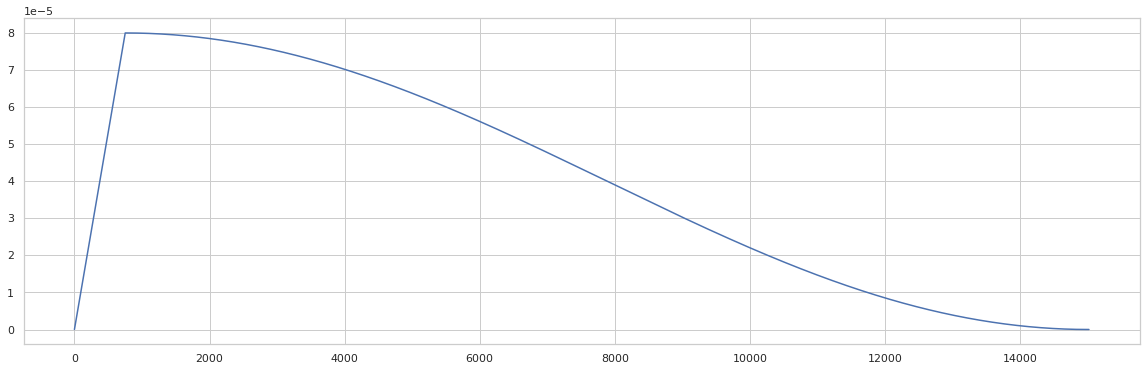

In [ ]:
lr_start = 1e-8
lr_min = 1e-8
lr_max = LEARNING_RATE
num_cycles = 1.
warmup_epochs = 1
hold_max_epochs = 0
total_epochs = EPOCHS
warmup_steps = warmup_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
total_steps = total_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)

@tf.function
def lrfn(step):
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, float(lr))

    return lr


# rng = [i for i in range(total_epochs)]
rng = [i for i in range(total_steps)]
y = [lrfn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

In [ ]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB7(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    base_model.trainable = False
    x = L.Dropout(.5)(base_model.output)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
#help(strategy)

# Training

In [ ]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(50))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in idxT])

    FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
    FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])

    TRAIN_FILENAMES = (FILENAMES_COMP + 
                       FILENAMES_2019 + 
                       (2 * FILENAMES_COMP_CBB) + 
                       (2 * FILENAMES_2019_CBB) + 
                       (2 * FILENAMES_COMP_CBSD) + 
                       (2 * FILENAMES_2019_CBSD) + 
                       (2 * FILENAMES_COMP_CGM) + 
                       (2 * FILENAMES_2019_CGM) + 
                       (2 * FILENAMES_COMP_Healthy) + 
                       (2 * FILENAMES_2019_Healthy))
    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    valid_step_size = (ct_valid // BATCH_SIZE)
    total_steps=(total_epochs * step_size)
    warmup_steps=(warmup_epochs * step_size)
    
    
    # Build TF datasets
    train_ds = strategy.experimental_distribute_dataset(get_dataset(TRAIN_FILENAMES, repeated=True, augment=True))
    valid_ds = strategy.experimental_distribute_dataset(get_dataset(VALID_FILENAMES, ordered=True, repeated=True, cached=True))
    train_data_iter = iter(train_ds)
    valid_data_iter = iter(valid_ds)
    
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities, label_smoothing=.3)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # update metrics
            train_accuracy.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            if COLAB:
                #print(COLAB)
                strategy.experimental_run_v2(train_step_fn, next(data_iter))
            else:
                strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            # update metrics
            valid_accuracy.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            if COLAB:
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
            else:
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    
    # Model
    model_path = models_path+f'model_{fold}.h5'
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"
        
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)))
        loss_fn = losses.categorical_crossentropy

        train_accuracy = metrics.CategoricalAccuracy()
        valid_accuracy = metrics.CategoricalAccuracy()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
    
    
    # Setup training loop
    step = 0
    epoch_steps = 0
    patience_cnt = 0
    best_val = 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    ### Train model
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Run training step
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size
            

        # Validation run at the end of each epoch
        if (step // step_size) > epoch:
            # Validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # Compute metrics
            history['accuracy'].append(train_accuracy.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE * epoch_steps))
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE * valid_epoch_steps))

            # Report metrics
            epoch_time = time.time() - epoch_start_time
            print(f'\nEPOCH {epoch+1}/{EPOCHS}')
            print(f'time: {epoch_time:0.1f}s',
                  f"loss: {history['loss'][-1]:0.4f}",
                  f"accuracy: {history['accuracy'][-1]:0.4f}",
                  f"val_loss: {history['val_loss'][-1]:0.4f}",
                  f"val_accuracy: {history['val_accuracy'][-1]:0.4f}",
                  f'lr: {lrfn(tf.cast(optimizer.iterations, tf.int32).numpy()):0.4g}')

            # Early stopping monitor
            if history['val_accuracy'][-1] >= best_val:
                best_val = history['val_accuracy'][-1]
                model.save_weights(model_path)
                print(f'Saved model weights at "{model_path}"')
                patience_cnt = 1
            else:
                patience_cnt += 1
            # if patience_cnt > ES_PATIENCE:
            #     print(f'Epoch {epoch:05d}: early stopping')
            #     break

                
            # Set up next epoch
            epoch = step // step_size
            epoch_steps = 0
            train_accuracy.reset_states()
            train_loss.reset_states()
            valid_accuracy.reset_states()
            valid_loss.reset_states()
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 0  1  3 ... 47 48 49] VALID: [ 2  4 10 11 22 27 28 31 38 41]
258072576/258068648 [==============================] - 2s 0us/step
Instructions for updating:
renamed to `run`


Instructions for updating:
renamed to `run`



EPOCH 1/20
time: 512.2s loss: 1.4076 accuracy: 0.5426 val_loss: 0.7749 val_accuracy: 0.8376 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 2/20
time: 249.0s loss: 1.2615 accuracy: 0.7238 val_loss: 0.6600 val_accuracy: 0.8748 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 3/20
time: 249.1s loss: 1.2347 accuracy: 0.7452 val_loss: 0.6265 val_accuracy: 0.8781 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 4/20


time: 249.2s loss: 1.2239 accuracy: 0.7541 val_loss: 0.6308 val_accuracy: 0.8878 lr: 7.518e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 5/20


time: 248.8s loss: 1.2134 accuracy: 0.7670 val_loss: 0.6560 val_accuracy: 0.8752 lr: 7.157e-05

EPOCH 6/20


time: 248.9s loss: 1.2033 accuracy: 0.7765 val_loss: 0.5911 val_accuracy: 0.8906 lr: 6.709e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 7/20


time: 249.1s loss: 1.1989 accuracy: 0.7800 val_loss: 0.6189 val_accuracy: 0.8866 lr: 6.188e-05

EPOCH 8/20


time: 249.4s loss: 1.1909 accuracy: 0.7927 val_loss: 0.6173 val_accuracy: 0.8875 lr: 5.607e-05

EPOCH 9/20


time: 249.1s loss: 1.1909 accuracy: 0.7935 val_loss: 0.6012 val_accuracy: 0.8913 lr: 4.982e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 10/20


time: 249.1s loss: 1.1798 accuracy: 0.8026 val_loss: 0.6225 val_accuracy: 0.8909 lr: 4.33e-05

EPOCH 11/20


time: 248.8s loss: 1.1775 accuracy: 0.8037 val_loss: 0.5929 val_accuracy: 0.8894 lr: 3.67e-05

EPOCH 12/20


time: 249.2s loss: 1.1698 accuracy: 0.8118 val_loss: 0.5798 val_accuracy: 0.8923 lr: 3.018e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 13/20


time: 249.8s loss: 1.1705 accuracy: 0.8132 val_loss: 0.5972 val_accuracy: 0.8935 lr: 2.393e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 14/20


time: 249.6s loss: 1.1605 accuracy: 0.8210 val_loss: 0.5875 val_accuracy: 0.8949 lr: 1.812e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 15/20


time: 249.4s loss: 1.1573 accuracy: 0.8255 val_loss: 0.5886 val_accuracy: 0.8939 lr: 1.291e-05

EPOCH 16/20


time: 249.3s loss: 1.1581 accuracy: 0.8250 val_loss: 0.5889 val_accuracy: 0.8939 lr: 8.434e-06

EPOCH 17/20


time: 249.6s loss: 1.1582 accuracy: 0.8245 val_loss: 0.5727 val_accuracy: 0.8932 lr: 4.821e-06

EPOCH 18/20


time: 249.5s loss: 1.1558 accuracy: 0.8276 val_loss: 0.5695 val_accuracy: 0.8963 lr: 2.167e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 19/20


time: 250.1s loss: 1.1534 accuracy: 0.8303 val_loss: 0.5712 val_accuracy: 0.8980 lr: 5.455e-07
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 20/20


time: 250.2s loss: 1.1533 accuracy: 0.8307 val_loss: 0.5845 val_accuracy: 0.8944 lr: 8e-05
#### FOLD 1 OOF Accuracy = 0.898


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2 ... 46 47 49] VALID: [ 7 14 18 26 29 33 34 35 45 48]



EPOCH 1/20
time: 495.4s loss: 1.4069 accuracy: 0.5462 val_loss: 0.6841 val_accuracy: 0.8546 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 2/20
time: 252.1s loss: 1.2576 accuracy: 0.7278 val_loss: 0.6506 val_accuracy: 0.8722 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 3/20
time: 247.1s loss: 1.2386 accuracy: 0.7394 val_loss: 0.6562 val_accuracy: 0.8892 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 4/20


time: 246.5s loss: 1.2245 accuracy: 0.7554 val_loss: 0.6471 val_accuracy: 0.8693 lr: 7.518e-05

EPOCH 5/20


time: 251.7s loss: 1.2133 accuracy: 0.7668 val_loss: 0.6370 val_accuracy: 0.8871 lr: 7.157e-05

EPOCH 6/20


time: 247.2s loss: 1.2056 accuracy: 0.7768 val_loss: 0.5914 val_accuracy: 0.8944 lr: 6.709e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 7/20


time: 246.8s loss: 1.1974 accuracy: 0.7804 val_loss: 0.6114 val_accuracy: 0.8944 lr: 6.188e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 8/20


time: 247.4s loss: 1.1920 accuracy: 0.7905 val_loss: 0.6009 val_accuracy: 0.8840 lr: 5.607e-05

EPOCH 9/20


time: 246.3s loss: 1.1877 accuracy: 0.7939 val_loss: 0.6045 val_accuracy: 0.8885 lr: 4.982e-05

EPOCH 10/20


time: 246.2s loss: 1.1845 accuracy: 0.7960 val_loss: 0.5921 val_accuracy: 0.8866 lr: 4.33e-05

EPOCH 11/20


time: 246.3s loss: 1.1772 accuracy: 0.8042 val_loss: 0.6005 val_accuracy: 0.8823 lr: 3.67e-05

EPOCH 12/20


time: 246.4s loss: 1.1736 accuracy: 0.8097 val_loss: 0.6115 val_accuracy: 0.8845 lr: 3.018e-05

EPOCH 13/20


time: 246.6s loss: 1.1671 accuracy: 0.8181 val_loss: 0.6078 val_accuracy: 0.8887 lr: 2.393e-05

EPOCH 14/20


time: 247.0s loss: 1.1658 accuracy: 0.8170 val_loss: 0.5826 val_accuracy: 0.8904 lr: 1.812e-05

EPOCH 15/20


time: 246.7s loss: 1.1612 accuracy: 0.8208 val_loss: 0.5929 val_accuracy: 0.8909 lr: 1.291e-05

EPOCH 16/20


time: 247.0s loss: 1.1613 accuracy: 0.8215 val_loss: 0.5907 val_accuracy: 0.8916 lr: 8.434e-06

EPOCH 17/20


time: 246.8s loss: 1.1571 accuracy: 0.8240 val_loss: 0.5768 val_accuracy: 0.8897 lr: 4.821e-06

EPOCH 18/20


time: 247.1s loss: 1.1584 accuracy: 0.8262 val_loss: 0.5748 val_accuracy: 0.8906 lr: 2.167e-06

EPOCH 19/20


time: 247.0s loss: 1.1583 accuracy: 0.8272 val_loss: 0.5730 val_accuracy: 0.8928 lr: 5.455e-07

EPOCH 20/20


time: 247.5s loss: 1.1562 accuracy: 0.8301 val_loss: 0.5852 val_accuracy: 0.8880 lr: 8e-05
#### FOLD 2 OOF Accuracy = 0.894


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  1  2 ... 47 48 49] VALID: [ 8 13 15 16 20 25 30 32 42 43]



EPOCH 1/20
time: 494.0s loss: 1.4061 accuracy: 0.5445 val_loss: 0.7706 val_accuracy: 0.8189 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 2/20
time: 246.5s loss: 1.2559 accuracy: 0.7286 val_loss: 0.7042 val_accuracy: 0.8707 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 3/20
time: 246.9s loss: 1.2420 accuracy: 0.7403 val_loss: 0.6768 val_accuracy: 0.8778 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 4/20
time: 247.0s loss: 1.2249 accuracy: 0.7538 val_loss: 0.6842 val_accuracy: 0.8788 lr: 7.518e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 5/20
time: 247.2s loss: 1.2120 accuracy: 0.7697 val_loss: 0.6304 val_accuracy: 0.8878 lr: 7.157e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 6/20
time: 247.2s

INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  2  3 ... 46 47 48] VALID: [ 1  5  6 12 17 23 24 37 40 49]

EPOCH 1/20
time: 504.2s loss: 1.4096 accuracy: 0.5409 val_loss: 0.7826 val_accuracy: 0.8381 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 2/20
time: 253.1s loss: 1.2653 accuracy: 0.7190 val_loss: 0.6312 val_accuracy: 0.8861 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 3/20
time: 253.0s loss: 1.2380 accuracy: 0.7443 val_loss: 0.6208 val_accuracy: 0.8880 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 4/20


time: 253.3s loss: 1.2268 accuracy: 0.7527 val_loss: 0.6491 val_accuracy: 0.8859 lr: 7.518e-05

EPOCH 5/20


time: 253.0s loss: 1.2158 accuracy: 0.7623 val_loss: 0.6258 val_accuracy: 0.8899 lr: 7.157e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 6/20


time: 253.2s loss: 1.2065 accuracy: 0.7734 val_loss: 0.6337 val_accuracy: 0.8942 lr: 6.709e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 7/20


time: 254.2s loss: 1.1988 accuracy: 0.7824 val_loss: 0.6011 val_accuracy: 0.8984 lr: 6.188e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 8/20


time: 253.4s loss: 1.1976 accuracy: 0.7800 val_loss: 0.6341 val_accuracy: 0.8954 lr: 5.607e-05

EPOCH 9/20


time: 253.5s loss: 1.1899 accuracy: 0.7921 val_loss: 0.6065 val_accuracy: 0.8942 lr: 4.982e-05

EPOCH 10/20


time: 253.4s loss: 1.1854 accuracy: 0.7963 val_loss: 0.5975 val_accuracy: 0.8980 lr: 4.33e-05

EPOCH 11/20


time: 254.2s loss: 1.1811 accuracy: 0.8018 val_loss: 0.5993 val_accuracy: 0.8977 lr: 3.67e-05

EPOCH 12/20


time: 253.8s loss: 1.1772 accuracy: 0.8049 val_loss: 0.6083 val_accuracy: 0.8937 lr: 3.018e-05

EPOCH 13/20


time: 254.7s loss: 1.1703 accuracy: 0.8133 val_loss: 0.5987 val_accuracy: 0.8975 lr: 2.393e-05

EPOCH 14/20


time: 254.1s loss: 1.1650 accuracy: 0.8177 val_loss: 0.6205 val_accuracy: 0.8935 lr: 1.812e-05

EPOCH 15/20


time: 253.6s loss: 1.1618 accuracy: 0.8230 val_loss: 0.5858 val_accuracy: 0.9034 lr: 1.291e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 16/20


time: 254.2s loss: 1.1626 accuracy: 0.8203 val_loss: 0.5813 val_accuracy: 0.9020 lr: 8.434e-06

EPOCH 17/20


time: 253.7s loss: 1.1588 accuracy: 0.8255 val_loss: 0.5756 val_accuracy: 0.9036 lr: 4.821e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 18/20


time: 254.3s loss: 1.1564 accuracy: 0.8243 val_loss: 0.5634 val_accuracy: 0.9032 lr: 2.167e-06

EPOCH 19/20


time: 254.4s loss: 1.1562 accuracy: 0.8261 val_loss: 0.5784 val_accuracy: 0.9015 lr: 5.455e-07

EPOCH 20/20


time: 254.2s loss: 1.1570 accuracy: 0.8266 val_loss: 0.5901 val_accuracy: 0.9003 lr: 8e-05
#### FOLD 4 OOF Accuracy = 0.904


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.216.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 1  2  4 ... 45 48 49] VALID: [ 0  3  9 19 21 36 39 44 46 47]



EPOCH 1/20
time: 504.3s loss: 1.4046 accuracy: 0.5461 val_loss: 0.7392 val_accuracy: 0.8395 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 2/20
time: 253.4s loss: 1.2639 accuracy: 0.7218 val_loss: 0.6596 val_accuracy: 0.8771 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 3/20
time: 253.1s loss: 1.2373 accuracy: 0.7443 val_loss: 0.6148 val_accuracy: 0.8861 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 4/20
time: 254.0s loss: 1.2245 accuracy: 0.7561 val_loss: 0.6898 val_accuracy: 0.8665 lr: 7.518e-05

EPOCH 5/20
time: 253.1s loss: 1.2137 accuracy: 0.7684 val_loss: 0.6181 val_accuracy: 0.8797 lr: 7.157e-05

EPOCH 6/20
time: 254.0s loss: 1.2096 accuracy: 0.7725 val_loss: 0.6219 val_accuracy: 0.8835 lr: 6.709e-05

EPOCH 7/20
time: 253.8s loss: 1.2006 accuracy: 0.7819 val_loss: 0.6077 val_accuracy: 0.8942 lr

## Model loss graph


FOLD: 1


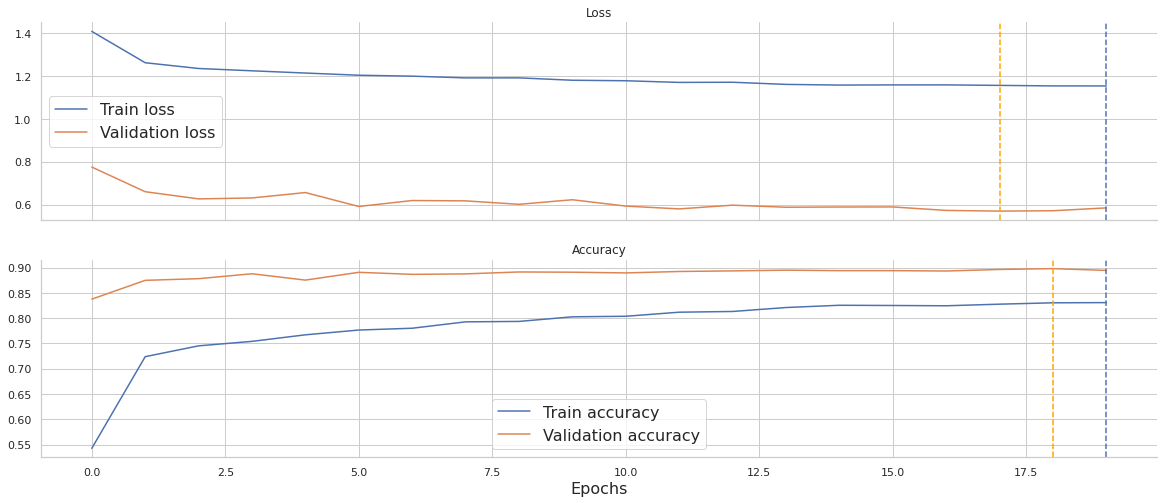


FOLD: 2


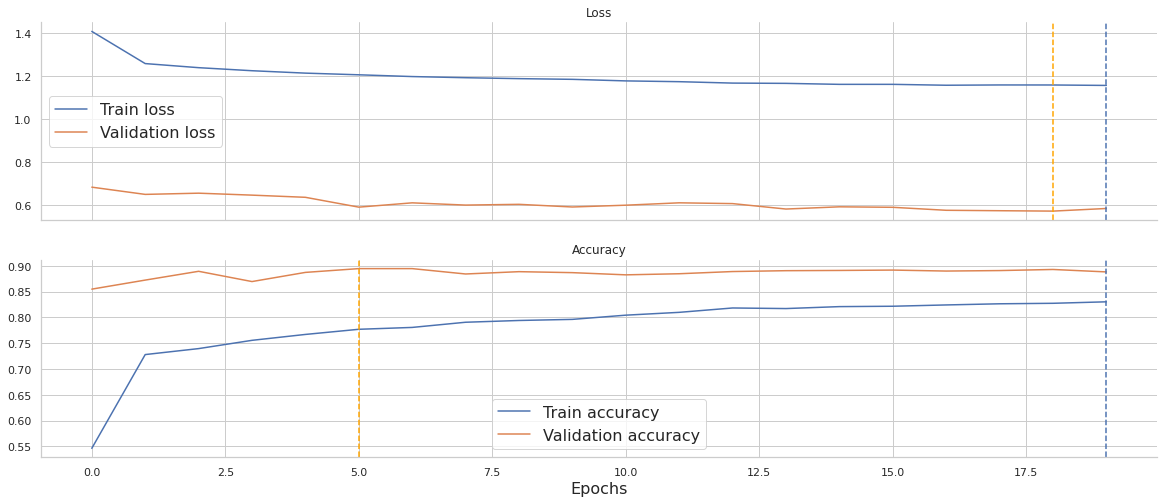


FOLD: 3


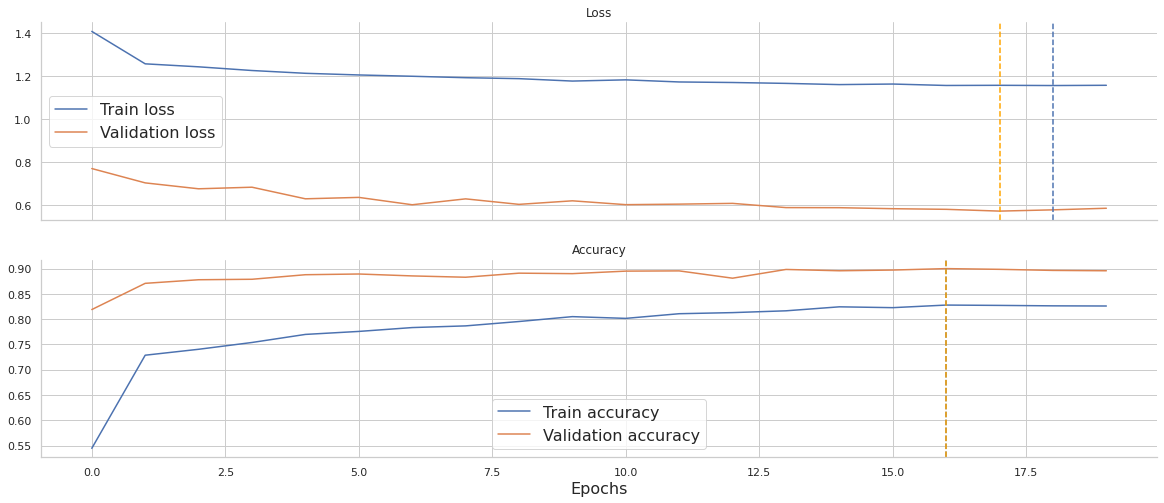


FOLD: 4


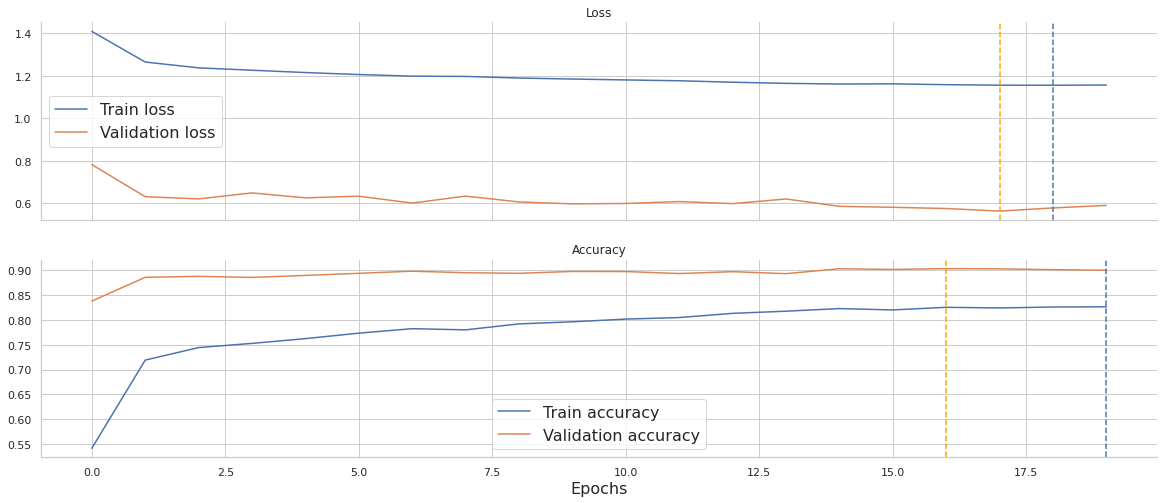


FOLD: 5


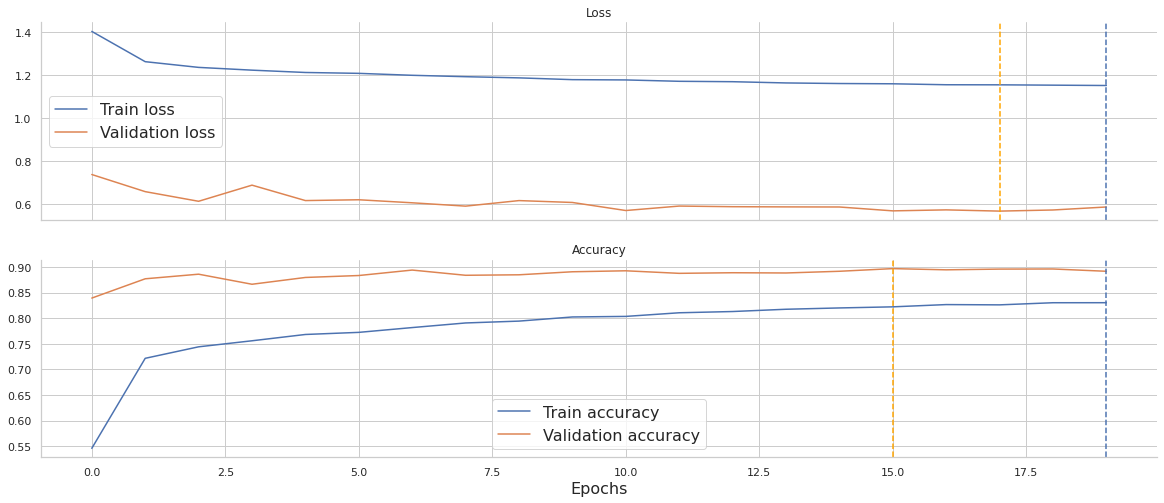

In [ ]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

#### I am still having some problems to get the real model `OOF` scores while using `TPU Pods`, so the results here and the confusion matrix are just placeholders.

In [ ]:
y_true = np.concatenate(oof_labels)
y_true = np.argmax(y_true, axis=-1)
y_pred = np.concatenate(oof_pred)

print(classification_report(y_true, y_pred, target_names=CLASSES))

                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.66      0.72      0.68      1086
Cassava Brown Streak Disease       0.85      0.84      0.84      2189
        Cassava Green Mottle       0.82      0.84      0.83      2386
      Cassava Mosaic Disease       0.97      0.96      0.97     13158
                     Healthy       0.77      0.74      0.76      2576

                    accuracy                           0.90     21395
                   macro avg       0.81      0.82      0.82     21395
                weighted avg       0.90      0.90      0.90     21395



# Confusion matrix

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

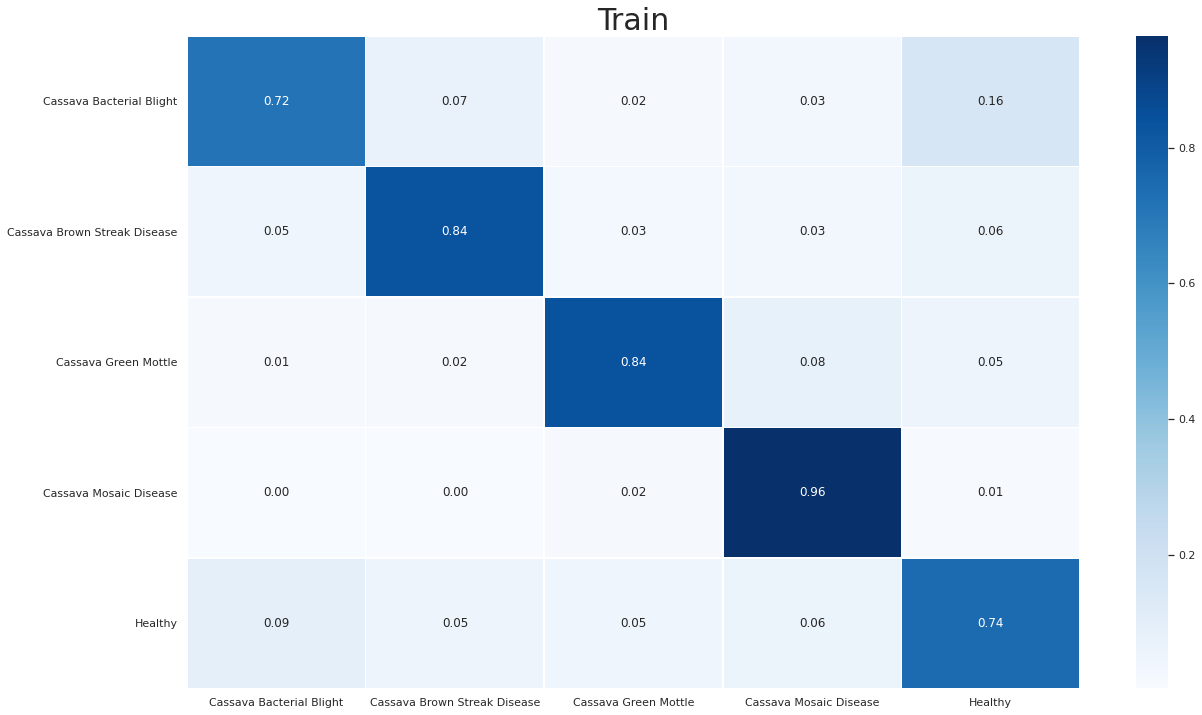

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, of if it is because the model is actually bad.


### Class map
```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```


## Train set

In [ ]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)
y_samp = np.argmax(y_samp, axis=-1)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)

In [26]:

save_data=True# You can immediately create a kaggle dataset from your models
if COLAB and save_data:
  
    import json


    
    data = {"title": "Cassava Leaf Disease", 
        "id": "aikhmelnytskyy/CassavaLeafDisease", 
        "licenses": [
                     {
                         "name": "CC0-1.0"
                      }
                     ]}
    

    # for kaggle api Connection
    
    !kaggle datasets init -p /content/drive/MyDrive/Colab Notebooks/Cassava/
    
    with open("/content/drive/MyDrive/Colab Notebooks/Cassava/dataset-metadata.json", "w", encoding="utf-8") as file:
        json.dump(data, file)
    
    #if new dataset
    !kaggle datasets create -p /content/drive/MyDrive/Models/Cassava/
    #If you’d like to upload a new version of an existing dataset
    #!kaggle datasets version -p /content/drive/MyDrive/Models/Cassava/ -m "Your message here"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
